In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wandb disabled

W&B disabled.


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 21.0 MB/s eta 0:00:00


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
from keras import backend as keras
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
!kaggle datasets download -d pkdarabi/bone-fracture-detection-computer-vision-project
!unzip bone-fracture-detection-computer-vision-project.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-fracture-detection-computer-vision-project
License(s): Attribution 4.0 International (CC BY 4.0)
 74%|████████████████████████████          | 62.0M/84.1M [00:00<00:00, 77.9MB/s]
100%|███████████████████████████████████████| 84.1M/84.1M [00:00<00:00, 109MB/s]


# **Data Exploration**
----

In [6]:
train_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
train_labels = '/kaggle/input/bone-fracture-detection-detection-coco-annots/train_annotations.coco.json'

test_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images'
test_labels = '/kaggle/input/bone-fracture-detection-detection-coco-annots/test_annotations.coco.json'

val_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images'
val_labels = '/kaggle/input/bone-fracture-detection-detection-coco-annots/valid_annotations.coco.json'

In [7]:
"""print('Number of train frames: ' + str(len(os.listdir(train_images))))
print('Number of train labels: ' + str(len(os.listdir(train_labels))))
print('Number of val frames: ' + str(len(os.listdir(val_images))))
print('Number of val labels: ' + str(len(os.listdir(val_labels))))
print('Number of test frames: ' + str(len(os.listdir(test_images))))
print('Number of test labels: ' + str(len(os.listdir(test_labels))))
print('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))"""

"print('Number of train frames: ' + str(len(os.listdir(train_images))))\nprint('Number of train labels: ' + str(len(os.listdir(train_labels))))\nprint('Number of val frames: ' + str(len(os.listdir(val_images))))\nprint('Number of val labels: ' + str(len(os.listdir(val_labels))))\nprint('Number of test frames: ' + str(len(os.listdir(test_images))))\nprint('Number of test labels: ' + str(len(os.listdir(test_labels))))\nprint('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))"

In [8]:
"""# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()"""

'# Get a list of all the image files in the training images directory\nimage_files = os.listdir(train_images)\n\n# Choose 16 random image files from the list\nrandom_images = random.sample(image_files, 16)\n\n# Set up the plot\nfig, axs = plt.subplots(4, 4, figsize=(16, 16))\n\n# Loop over the random images and plot the object detections\nfor i, image_file in enumerate(random_images):\n    row = i // 4\n    col = i % 4\n\n    # Load the image\n    image_path = os.path.join(train_images, image_file)\n    image = cv2.imread(image_path)\n\n    # Load the labels for this image\n    label_file = os.path.splitext(image_file)[0] + ".txt"\n    label_path = os.path.join(train_labels, label_file)\n    with open(label_path, "r") as f:\n        labels = f.read().strip().split("\n")\n\n    # Loop over the labels and plot the object detections\n    # Loop over the labels and plot the object detections\n    for label in labels:\n        if len(label.split()) != 5:\n            continue\n        class

# **Modeling**
----

In [9]:
image = cv2.imread('/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/images/distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1.jpg')

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 1024x1024 and 3 channels.


In [10]:
# Loading a pretrained model
model = YOLO('yolov8s.pt')

# Training the model
model.train(data = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/data.yaml',
            epochs = 35,
            imgsz = height,
            seed = 42

)

100%|██████████| 21.5M/21.5M [00:00<00:00, 111MB/s] 


Ultralytics 8.3.51 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/data.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

100%|██████████| 755k/755k [00:00<00:00, 26.4MB/s]
2024-12-20 07:02:03,671	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-20 07:02:04,142	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 112MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:16<00:00, 213.85it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:01<00:00, 192.34it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35       9.2G      2.618      10.74      2.539         16       1024: 100%|██████████| 227/227 [02:29<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]

                   all        348        204    0.00112      0.459    0.00264   0.000744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      9.15G        2.4      4.432      2.469         18       1024: 100%|██████████| 227/227 [02:27<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        348        204      0.586     0.0143      0.023    0.00719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      9.05G      2.394       4.08      2.519         19       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]

                   all        348        204     0.0686     0.0575     0.0404     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      9.13G      2.378      4.024      2.585         24       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.75it/s]

                   all        348        204      0.319     0.0537     0.0616     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      9.05G       2.31      3.789      2.531         21       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

                   all        348        204      0.579     0.0936     0.0711     0.0243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      8.98G      2.245      3.556      2.436         12       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

                   all        348        204      0.315      0.122      0.122     0.0387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      9.08G      2.186      3.356      2.367         20       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.67it/s]

                   all        348        204      0.301      0.178      0.124     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      9.13G      2.145      3.225      2.374         21       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

                   all        348        204      0.283      0.163      0.119     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      9.05G      2.068      3.093      2.313         12       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

                   all        348        204      0.204      0.177      0.151     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      9.08G      2.045      2.942      2.291         13       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

                   all        348        204       0.34      0.203      0.158     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      9.08G      2.036      2.898      2.253         26       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]

                   all        348        204      0.198      0.245      0.148     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      9.14G      1.989      2.791      2.234         18       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

                   all        348        204       0.23      0.191      0.172     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      9.56G      1.941      2.695      2.179         12       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

                   all        348        204      0.612      0.146      0.179     0.0641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      9.08G      1.928      2.569      2.188         17       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

                   all        348        204      0.258      0.245      0.164     0.0619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      9.08G      1.893      2.523       2.17         19       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

                   all        348        204       0.22      0.213      0.177     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      9.14G      1.876      2.433      2.105         15       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        348        204      0.251      0.234      0.189     0.0747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      9.05G      1.817       2.31       2.07         14       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        348        204      0.211      0.213      0.186     0.0721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      9.08G      1.762      2.158      2.035         18       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

                   all        348        204      0.287       0.22      0.209     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      9.07G      1.765       2.15      2.029         15       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

                   all        348        204      0.281      0.276      0.216     0.0747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      9.12G      1.729      2.062      1.991         18       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

                   all        348        204      0.339      0.292      0.224     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      9.55G      1.676      1.923      1.948         16       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

                   all        348        204      0.318      0.267       0.22     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      8.98G      1.633       1.89      1.922         15       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

                   all        348        204      0.266      0.246      0.221     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      9.07G      1.607      1.806      1.892         23       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

                   all        348        204      0.283      0.256      0.219     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      9.12G       1.57      1.712      1.845         16       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

                   all        348        204      0.368      0.278      0.218     0.0834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      9.56G      1.544      1.671      1.834         27       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        348        204      0.312      0.298       0.21     0.0715


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      9.59G      1.491      1.486      1.916         12       1024: 100%|██████████| 227/227 [02:27<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

                   all        348        204      0.328      0.295      0.243     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      8.98G      1.413      1.329       1.87          7       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

                   all        348        204      0.404      0.304      0.248     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      9.13G      1.396      1.289       1.84         12       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

                   all        348        204      0.297      0.305      0.245     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      9.04G      1.352       1.25        1.8          8       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        348        204      0.362      0.313       0.26     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      8.98G      1.317      1.148      1.764         10       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

                   all        348        204      0.349       0.26      0.243     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      9.08G      1.276      1.088      1.706          7       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        348        204      0.311      0.291      0.247     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      9.13G      1.228      1.015      1.672         14       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

                   all        348        204      0.295      0.317      0.246      0.091



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      9.56G       1.16      0.951      1.615          9       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

                   all        348        204      0.331      0.301      0.254     0.0915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      9.08G      1.146     0.9173      1.604          6       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

                   all        348        204      0.392      0.249      0.255     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      9.08G      1.098     0.8653       1.55          6       1024: 100%|██████████| 227/227 [02:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        348        204      0.344      0.288      0.246      0.087



35 epochs completed in 1.475 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


                   all        348        204      0.361      0.313      0.259     0.0914
        elbow positive         28         29      0.187      0.172      0.089     0.0258
      fingers positive         41         48      0.303      0.235      0.194     0.0517
      forearm fracture         37         43      0.475      0.419      0.448      0.194
               humerus         31         36       0.68      0.528       0.55      0.181
     shoulder fracture         19         20       0.37       0.45      0.226     0.0838
        wrist positive         17         28      0.153     0.0714     0.0447      0.013
Speed: 0.4ms preprocess, 9.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cddf81a4a60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

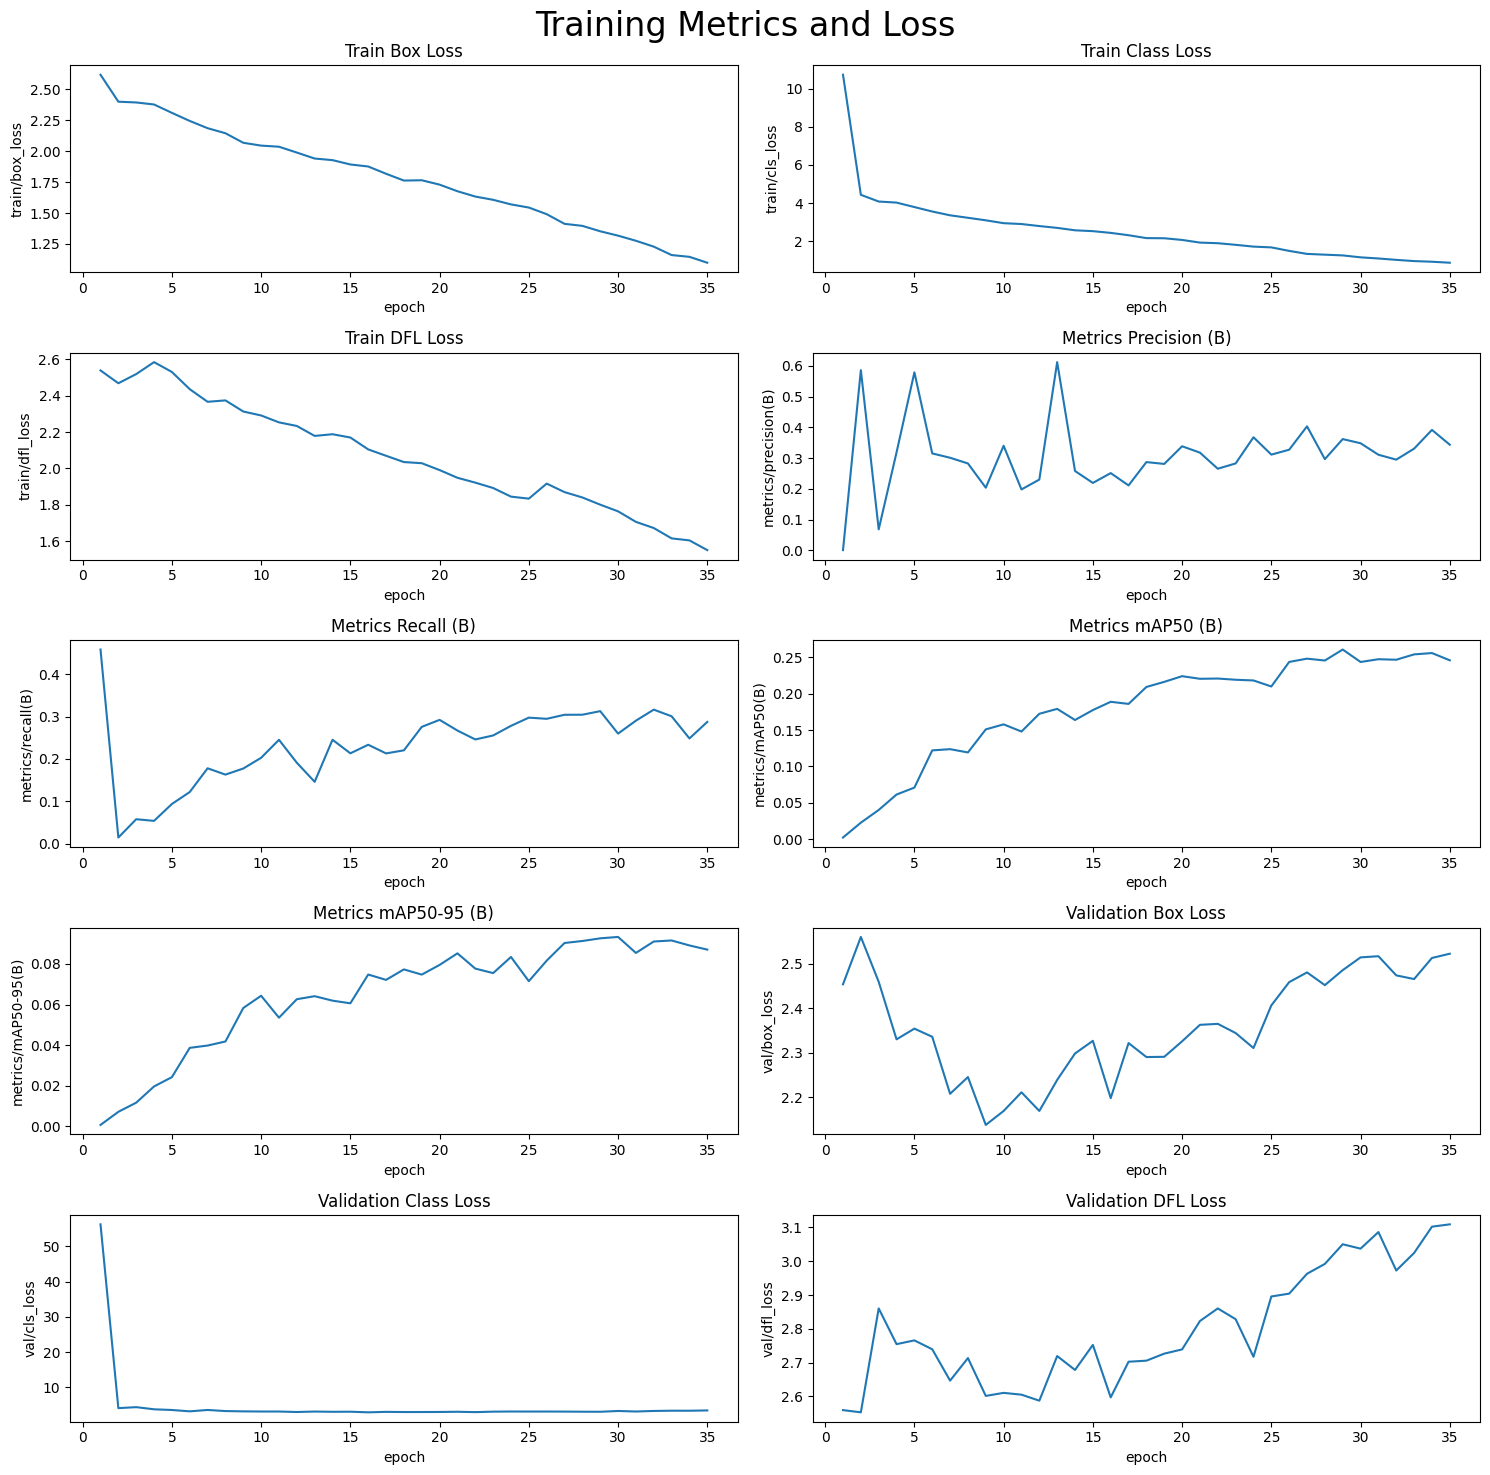

In [11]:
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# **Evaluation**
----

In [12]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.51 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/labels... 169 images, 86 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<00:00, 229.90it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


                   all        169         96      0.335      0.174      0.237     0.0835
        elbow positive         13         17      0.125     0.0588     0.0672     0.0134
      fingers positive         22         27      0.182     0.0741      0.109     0.0218
      forearm fracture         13         14      0.714      0.357      0.566      0.233
               humerus         14         15      0.571      0.267      0.387      0.114
     shoulder fracture         15         17       0.25      0.118       0.14     0.0419
        wrist positive          6          6      0.167      0.167      0.152     0.0761
Speed: 0.4ms preprocess, 13.2ms inference, 0.1ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val


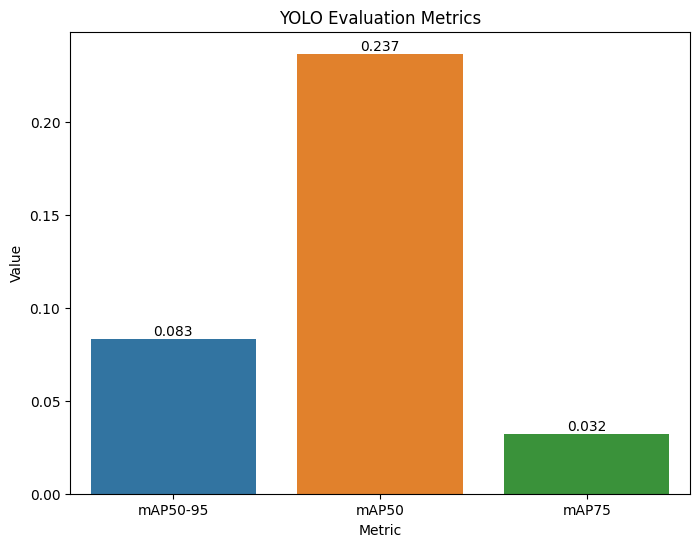

In [13]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

**Confusion Matrix**

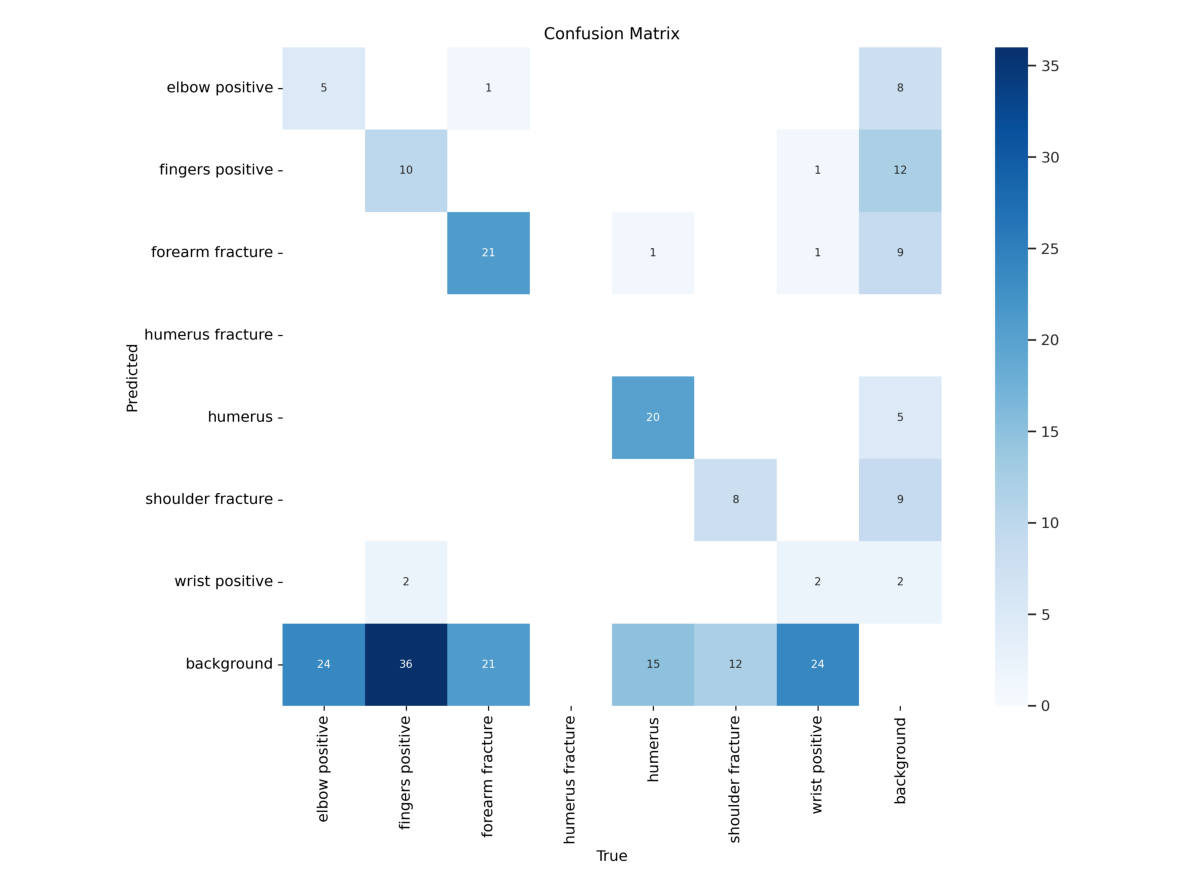

In [14]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# **Making Predictions on Test Images**
---

In [15]:
#Dari sananya

#Function to perform ship detections
# def ship_detect(img_path):
    
#     # Read the image
#     img = cv2.imread(img_path)

#     # Pass the image through the detection model and get the result
#     detect_result = model(img)

#     # Plot the detections
#     detect_img = detect_result[0].plot()
    
#     # Convert the image to RGB format
#     detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
#     return detect_img


In [16]:
#yang dbikin baru
def ship_detect_with_boxes(img_path):
    """
    Detect objects in an image, return the image with bounding boxes, and the predicted boxes.
    """
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model
    detect_result = model(img)

    # Extract predictions: boxes, scores, and class labels
    boxes = detect_result[0].boxes.xyxy.cpu().numpy()  # Bounding box coordinates (x1, y1, x2, y2)
    scores = detect_result[0].boxes.conf.cpu().numpy()  # Confidence scores
    labels = detect_result[0].boxes.cls.cpu().numpy()  # Class labels

    # Annotate the image with predictions
    detect_img = img.copy()
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = map(int, box)
        label_text = f"Class {int(label)}: {score:.2f}"
        cv2.rectangle(detect_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw bounding box
        cv2.putText(detect_img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Convert BGR to RGB for display
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img, boxes


0: 1024x672 (no detections), 41.2ms
Speed: 7.9ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 672)

0: 1024x768 (no detections), 42.0ms
Speed: 7.0ms preprocess, 42.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 768)

0: 512x1024 (no detections), 54.4ms
Speed: 2.6ms preprocess, 54.4ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 1024)

0: 1024x320 1 forearm fracture, 39.5ms
Speed: 2.3ms preprocess, 39.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 320)

0: 1024x480 (no detections), 40.4ms
Speed: 2.5ms preprocess, 40.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 480)

0: 864x1024 (no detections), 39.7ms
Speed: 8.4ms preprocess, 39.7ms inference, 0.5ms postprocess per image at shape (1, 3, 864, 1024)

0: 1024x384 1 fingers positive, 39.8ms
Speed: 2.6ms preprocess, 39.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 384)

0: 1024x832 1 fingers positive, 39.3ms
Speed: 5.

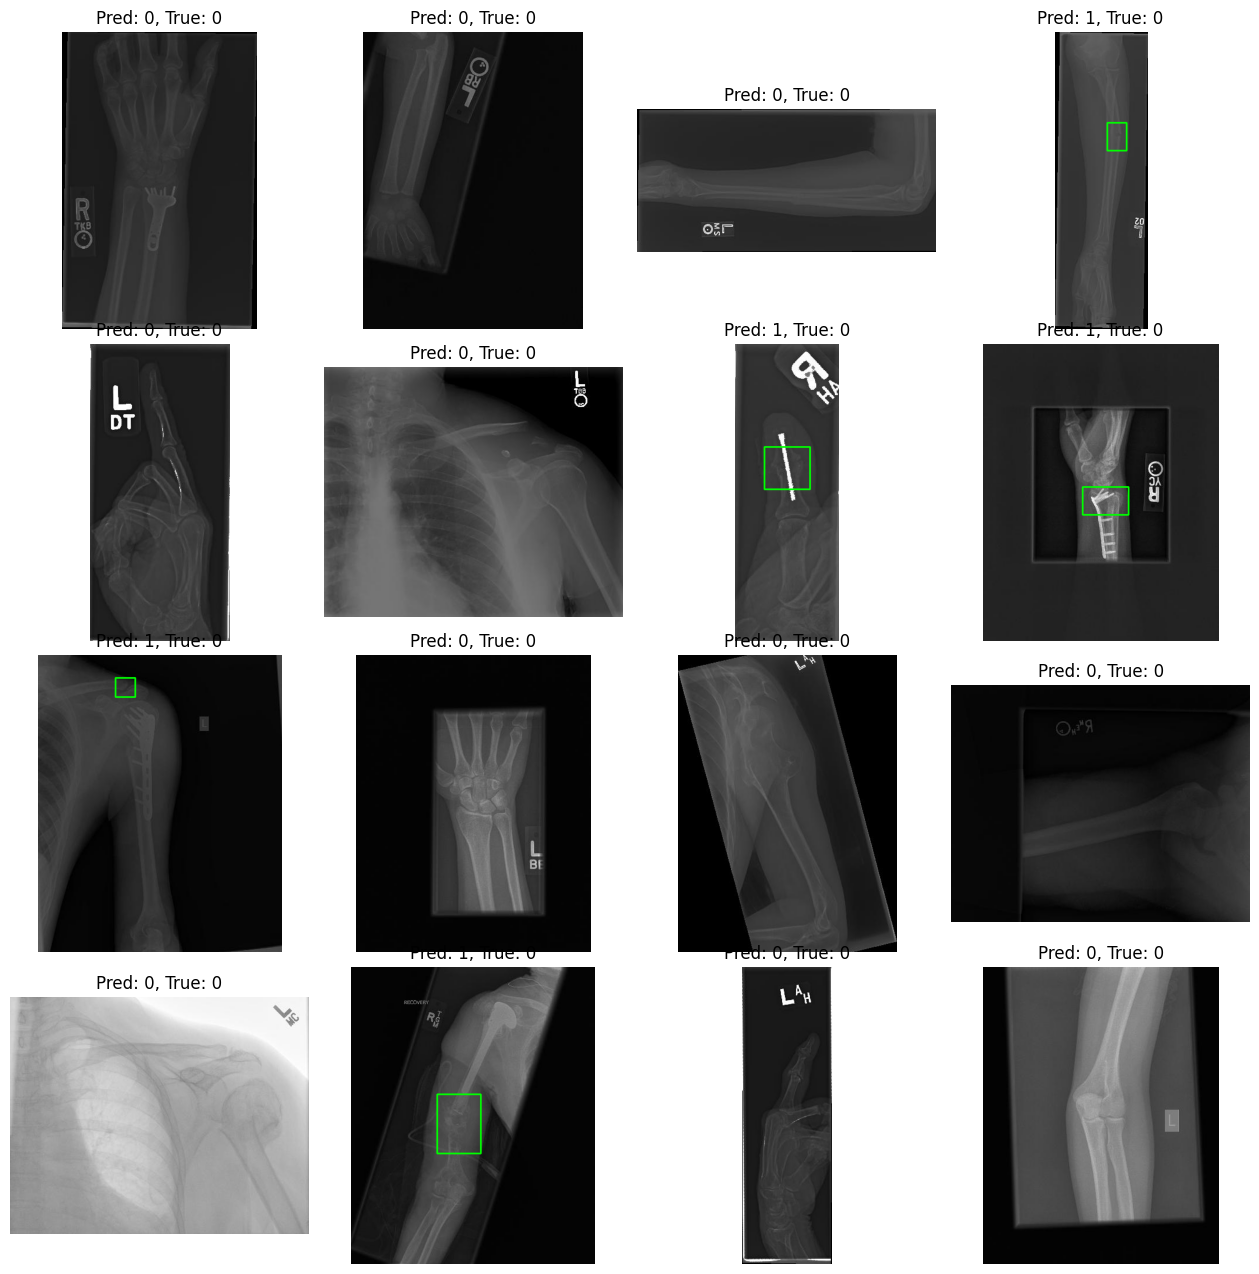

In [17]:
import matplotlib.patches as patches

# Helper function to draw bounding boxes
def draw_bounding_boxes(image, boxes, color, thickness=2):
    """
    Draws bounding boxes on an image.
    Args:
        image: Image array.
        boxes: List of bounding boxes in (x1, y1, x2, y2) format.
        color: Color of the bounding boxes (BGR format).
        thickness: Thickness of the bounding box lines.
    Returns:
        Annotated image.
    """
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    return image

# Get the list of test image files
image_files = os.listdir(test_images)

# Select 16 random images
selected_images = random.sample(image_files, 16)

# Set up subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Iterate over the selected images
for i, img_file in enumerate(selected_images):
    row_idx = i // 4
    col_idx = i % 4

    # Load the image
    img_path = os.path.join(test_images, img_file)
    image = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load the corresponding ground truth labels
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = os.path.join(test_labels, label_file)
    true_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")
            for label in labels:
                if len(label.split()) != 5:
                    continue
                class_id, x_center, y_center, width, height = map(float, label.split())
                x_min = (x_center - width / 2) * image.shape[1]
                y_min = (y_center - height / 2) * image.shape[0]
                x_max = (x_center + width / 2) * image.shape[1]
                y_max = (y_center + height / 2) * image.shape[0]
                true_boxes.append([x_min, y_min, x_max, y_max])

    # Detect objects using the model
    detect_result = model(image)
    pred_boxes = detect_result[0].boxes.xyxy.cpu().numpy()

    # Draw predicted and ground truth bounding boxes
    img_with_preds = draw_bounding_boxes(img_rgb.copy(), pred_boxes, color=(0, 255, 0))  # Green for predictions
    img_with_both = draw_bounding_boxes(img_with_preds, true_boxes, color=(255, 0, 0))   # Red for ground truth

    # Display the image
    axes[row_idx, col_idx].imshow(img_with_both)
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_title(f"Pred: {len(pred_boxes)}, True: {len(true_boxes)}")

# Adjust subplot layout
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


In [18]:
"""import random

# Define the directory where the custom images are stored
custom_image_dir = test_images

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img, boxes = ship_detect_with_boxes(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_title(f"Boxes: {len(boxes)}")  # Show number of detections
    
    ground_truth = next(
        (item for item in test_dataset_dicts if os.path.basename(item['file_name']) == img_file),
        None,
    )
    true_boxes = [anno['bbox'] for anno in ground_truth['annotations']] if ground_truth else []
    
    # Convert ground truth boxes to format (x1, y1, x2, y2) if needed
    true_boxes = [[x, y, x + w, y + h] for x, y, w, h in true_boxes]

    # Draw both predictions and ground truth on the image
    img_with_preds = draw_bounding_boxes(img_rgb, pred_boxes, color=(255, 0, 0), thickness=2)
    img_with_both = draw_bounding_boxes(img_with_preds, true_boxes, color=(0, 255, 0), thickness=2)
    
    # Plot the image on the appropriate subplot
    axes[row_idx, col_idx].imshow(img_with_both)
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_title(f"Pred: {len(pred_boxes)}, True: {len(true_boxes)}")  # Show counts

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()"""

'import random\n\n# Define the directory where the custom images are stored\ncustom_image_dir = test_images\n\n# Get the list of image files in the directory\nimage_files = os.listdir(custom_image_dir)\n\n# Select 16 random images from the list\nselected_images = random.sample(image_files, 16)\n\n# Create a figure with subplots for each image\nfig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))\n\n# Iterate over the selected images and plot each one\nfor i, img_file in enumerate(selected_images):\n    \n    # Compute the row and column index of the current subplot\n    row_idx = i // 4\n    col_idx = i % 4\n    \n    # Load the current image and run object detection\n    img_path = os.path.join(custom_image_dir, img_file)\n    detect_img, boxes = ship_detect_with_boxes(img_path)\n    \n    # Plot the current image on the appropriate subplot\n    axes[row_idx, col_idx].imshow(detect_img)\n    axes[row_idx, col_idx].axis(\'off\')\n    axes[row_idx, col_idx].set_title(f"Boxes: {l